In [2]:
import pandas as pd
import numpy as np
import pickle
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Conv1D
from keras.layers import MaxPool1D
from keras.layers import Flatten
from keras.layers import Dropout
from keras import optimizers
from math import sqrt
from keras.utils import to_categorical
import seaborn as sns
import keras
from keras.callbacks import ModelCheckpoint
from keras_adabound import AdaBound
from mlxtend.plotting import plot_confusion_matrix
import matplotlib
import xgboost
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import AdaBoostClassifier
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SVMSMOTE

## Zero Non Zero Click Level

In [3]:
df=pd.read_csv('./fdf-embedd.csv')
df = df.drop(df.columns[0], axis=1)
df=df.fillna(-1)
df["nDate"]=pd.to_datetime(df.date,format='%Y-%m-%d')

In [4]:
df=df.assign(first_level=0)
df.loc[df['clicks_level']!=0, 'first_level'] =1

# df=df.assign(second_level=1)
# df.loc[df['clicks_level']==2, 'second_level'] =2

In [5]:
df["nDate"]=pd.to_datetime(df.date,format='%Y-%m-%d')
df["date"]=df.date.astype(str)
df["Year"]=df.date.str[:4]
df["Month"]=df.date.str[5:7]
df["Day"]=df.date.str[8:]


df["Year"]=df.Year.astype(int)
df["Month"]=df.Month.astype(int)
df["Day"]=df.Day.astype(int)

In [6]:
labels=df["first_level"]
labels_final=df["clicks_level"]
df=df.drop(['nDate','query','date','first_level','clicks_level','tomorrow_net_clicks'],axis=1)

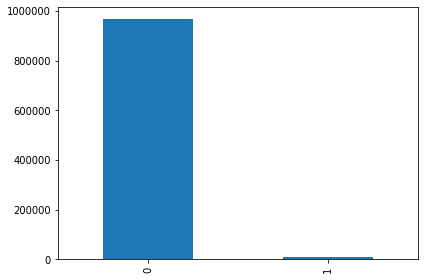

In [7]:
pd.value_counts(labels).plot.bar()
plt.tight_layout()


In [7]:
values=df.values
y=labels.copy()
n_train_hours=880874 
train_X ,train_y= values[:n_train_hours, :],y[:n_train_hours]
test_X,test_y = values[n_train_hours:, :],y[n_train_hours:]

In [9]:
# SMOTE
sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_sample(train_X, train_y)

In [8]:
# ADASYN
sm = ADASYN(random_state=20,n_jobs=-1)
X_train_sm, y_train_sm = sm.fit_sample(train_X, train_y)

In [ ]:
# SVMSMOTE
sm = SVMSMOTE(random_state=20,n_jobs=4)
X_train_sm, y_train_sm = sm.fit_sample(train_X, train_y)

In [10]:
np.unique(y_train_sm, return_counts=True)

(array([0, 1]), array([873338, 873338]))

In [21]:
def adaboost(X_train, y_train):
    model = AdaBoostClassifier(n_estimators=20, random_state=42)
    model.fit(X_train,y_train)
    return model

model=adaboost(X_train_sm,y_train_sm)
pred=model.predict(test_X)

In [9]:
def build_model(lr=0.1,depth=8,estimators=10):
    clf=xgboost.XGBClassifier(learning_rate = lr,max_depth = depth,early_stopping_rounds=10,n_estimators = estimators,min_child_weight= 1, scale_pos_weight= 1,colsample_bytree=0.8,n_jobs=-1,subsample=0.5)
    return clf

# eset = [(X_train_sm, y_train_sm), (test_X, test_y)]
model=build_model(lr=0.1,depth=3,estimators=10)
model.fit(X_train_sm,y_train_sm,verbose=True)
pred=model.predict(test_X)

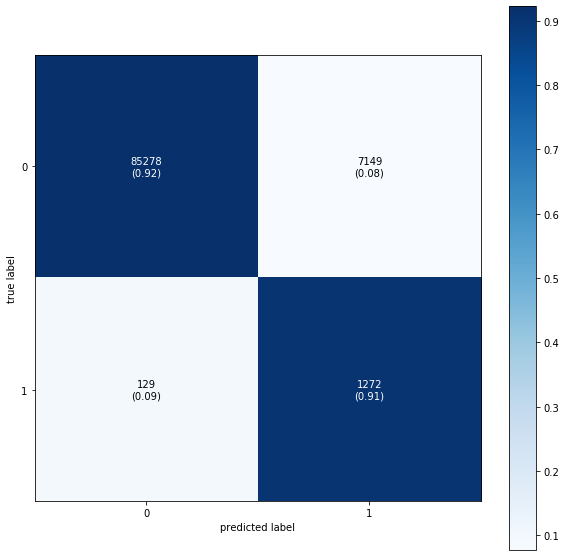

In [10]:
conf=sklearn.metrics.confusion_matrix(test_y,pred,labels=[0,1])
fig, ax = plot_confusion_matrix(conf_mat=conf,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                               figsize=(10,10))

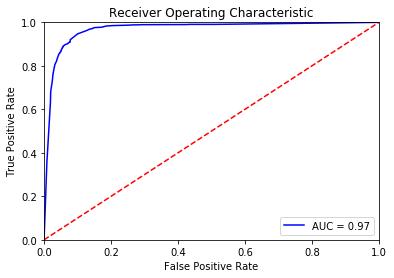

In [14]:
prob=model.predict_proba(test_X)
preds = prob[:,1]
fpr, tpr, threshold = sklearn.metrics.roc_curve(test_y, preds)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [15]:
from pycm import ConfusionMatrix
cm = ConfusionMatrix(actual_vector=test_y.tolist(), predict_vector=pred)
print (cm.AUC)
print (cm.AUCI)
print (cm.Kappa)

{0: 0.9166567914040339, 1: 0.9166567914040339}
{0: 'Excellent', 1: 'Excellent'}
0.2519233335781223


## 2nd Level

In [25]:
df['pred_level1']=model.predict(df.values)

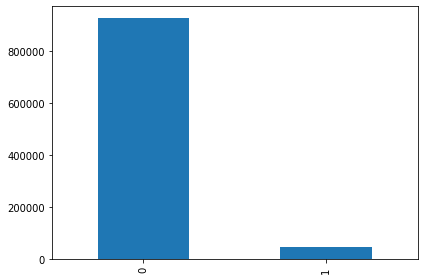

In [26]:
pd.value_counts(df['pred_level1']).plot.bar()
plt.tight_layout()

In [27]:
df[df['pred_level1']==1]

,bot_clicks_feature,bcfeature1,bcfeature2,bcfeature3,bcfeature4,cfeature4,ifeature4,pfeature4,cfeature5,cfeature6,...,roll_p_feature2_all,roll_p_feature3_all,roll_p_feature7_all,roll_p_feature30_all,Mean,Median,Year,Month,Day,pred_level1
93,0,0,0,0,0,0,1,6.0,0,0,...,37.354981,38.114445,38.424932,33.990731,-0.011275,0.003579,2019,6,21,1
146,0,0,0,0,0,0,0,-1.0,0,0,...,37.354981,38.114445,38.424932,33.990731,-0.010772,0.004349,2019,6,21,1
150,0,0,0,0,0,0,1,6.0,0,0,...,37.354981,38.114445,38.424932,33.990731,-0.010676,-0.002384,2019,6,21,1
153,0,0,0,0,0,0,9,8.0,0,0,...,37.354981,38.114445,38.424932,33.990731,-0.010058,0.005310,2019,6,21,1
155,0,0,0,0,0,0,5,8.0,0,0,...,37.354981,38.114445,38.424932,33.990731,-0.009662,0.006807,2019,6,21,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974681,0,0,0,0,0,0,1,10.0,0,0,...,25.873646,25.315629,25.983718,26.978020,-0.010689,-0.004787,2019,10,2,1
974683,0,1,0,0,0,0,5,13.0,0,0,...,25.873646,25.315629,25.983718,26.978020,-0.010845,-0.000999,2019,10,2,1
974685,0,0,0,0,0,0,0,-1.0,0,0,...,25.873646,25.315629,25.983718,26.978020,-0.010502,-0.005799,2019,10,2,1
974696,0,0,0,0,0,0,28,10.0,0,0,...,25.873646,25.315629,25.983718,26.978020,-0.012149,-0.005051,2019,10,2,1


In [28]:
ndf=pd.read_csv('./fdf-embedd.csv')
ndf = ndf.drop(df.columns[0], axis=1)
ndf=ndf.fillna(-1)

In [32]:
labels=ndf["clicks_level"]
labels=labels[df[df['pred_level1']==1].index]

In [33]:
# labels[labels==0]=1
np.unique(labels, return_counts=True)

(array([0, 1, 2]), array([40533,  4841,  3090]))

In [21]:
values=df[df['pred_level1']==1].drop(['pred_level1'],axis=1).values
y=labels.copy()
n_train_hours=30000
train_X ,train_y= values[:n_train_hours, :],y[:n_train_hours]
test_X,test_y = values[n_train_hours:, :],y[n_train_hours:]

In [22]:
train_X.shape,train_y.shape

((30000, 65), (30000,))

In [23]:
test_X.shape,test_y.shape

((8845, 65), (8845,))

In [24]:
# SMOTE
sm = SMOTE(random_state=50)
X_train_sm, y_train_sm = sm.fit_sample(train_X, train_y)

In [25]:
np.unique(y_train_sm, return_counts=True)

(array([1, 2]), array([27570, 27570]))

In [24]:
rgr=xgboost.XGBRegressor(max_depth=3,estimators=10)
rgr.fit(train_X,train_y)

/home/bot/virtual_enviornments/sleepare/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/home/bot/virtual_enviornments/sleepare/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[08:05:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, estimators=10, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [26]:
pred=rgr.predict(test_X)
print (sklearn.metrics.mean_squared_error(test_y,pred))

1.088244582643446


In [29]:
df=df.assign(final_pred=0)
df.loc[df['pred_level1']==1, 'final_pred'] =1
pred=rgr.predict(df[df.final_pred==1].drop(['pred_level1','final_pred'],axis=1).values)

In [31]:
ndf=df[df.final_pred==1]
ndf["final_pred"]=pred
df.loc[ndf.index,'final_pred']=ndf.final_pred

/home/bot/virtual_enviornments/sleepare/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [32]:
print (sklearn.metrics.mean_squared_error(test_y,pred))

,bot_clicks_feature,bcfeature1,bcfeature2,bcfeature3,bcfeature4,cfeature4,ifeature4,pfeature4,cfeature5,cfeature6,...,roll_p_feature3_all,roll_p_feature7_all,roll_p_feature30_all,Mean,Median,Year,Month,Day,pred_level1,final_pred
0,0,0,0,0,0,0,0,-1.0,0,0,...,38.114445,38.424932,33.990731,-0.014119,0.003428,2019,6,21,0,0.0
1,0,0,0,0,0,0,0,-1.0,0,0,...,38.114445,38.424932,33.990731,-0.010589,0.006418,2019,6,21,0,0.0
2,0,0,0,0,0,0,0,-1.0,0,0,...,38.114445,38.424932,33.990731,-0.010928,0.000463,2019,6,21,0,0.0
3,0,0,0,0,0,0,0,-1.0,0,0,...,38.114445,38.424932,33.990731,-0.011061,0.001539,2019,6,21,0,0.0
4,0,0,0,0,0,0,0,-1.0,0,0,...,38.114445,38.424932,33.990731,-0.010018,0.005830,2019,6,21,0,0.0


In [26]:
def adaboost(X_train, y_train):
    model = AdaBoostClassifier(n_estimators=10, random_state=42)
    model.fit(X_train,y_train)
    return model

model_2=adaboost(X_train_sm,y_train_sm)
pred=model_2.predict(test_X)

In [28]:
def build_model(lr=0.1,depth=8,estimators=10):
    clf=xgboost.XGBClassifier(learning_rate = lr,max_depth = depth,early_stopping_rounds=10,n_estimators = estimators,min_child_weight= 1, scale_pos_weight= 1,colsample_bytree=0.8,subsample=0.6)
    return clf

# eset = [(X_train_sm, y_train_sm), (test_X, test_y)]
model_2=build_model(lr=0.08,depth=3,estimators=10)
model_2.fit(X_train_sm,y_train_sm,verbose=True)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              early_stopping_rounds=10, gamma=0, learning_rate=0.08,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
              n_estimators=10, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=0.6, verbosity=1)

In [29]:
pred=model_2.predict(test_X)

[Text(0, 0, ''), Text(0, 0, '1'), Text(0, 0, '2')]

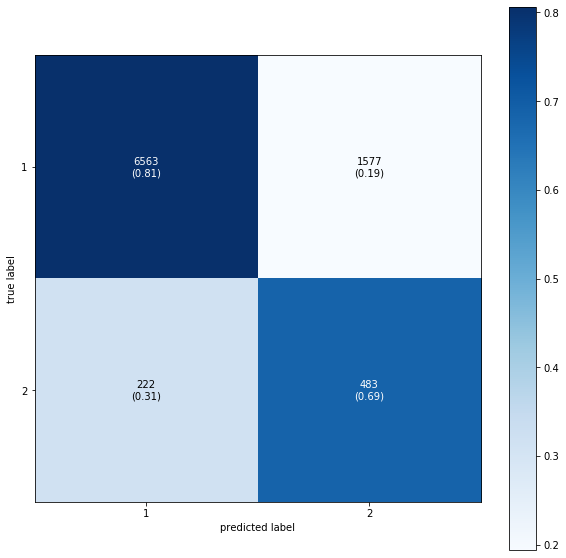

In [30]:
conf=sklearn.metrics.confusion_matrix(test_y,pred,labels=[1,2])
fig, ax = plot_confusion_matrix(conf_mat=conf,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                               figsize=(10,10)
                               )


labels=['','1','2']
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

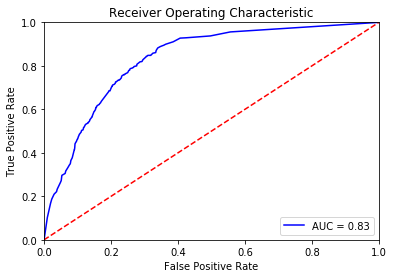

In [40]:
prob=model_2.predict_proba(test_X)
preds = prob[:,1]
pred[pred==1]=0
pred[pred==2]=1

test_y[test_y==1]=0
test_y[test_y==2]=1


fpr, tpr, threshold = sklearn.metrics.roc_curve(test_y, preds)
roc_auc = sklearn.metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [31]:
df=df.assign(final_pred=0)
df.loc[df['pred_level1']==1, 'final_pred'] =1

In [32]:
fp=model_2.predict(df[df.final_pred==1].drop(['pred_level1','final_pred'],axis=1).values)

In [33]:
ndf=df[df.final_pred==1]
ndf["final_pred"]=fp

/home/bot/virtual_enviornments/sleepare/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [34]:
df.loc[ndf.index,'final_pred']=ndf.final_pred

In [103]:
df.iloc[880874:]

,bot_clicks_feature,bcfeature1,bcfeature2,bcfeature3,bcfeature4,cfeature4,ifeature4,pfeature4,cfeature5,cfeature6,...,roll_p_feature3_all,roll_p_feature7_all,roll_p_feature30_all,Mean,Median,Year,Month,Day,pred_level1,final_pred
880874,0,0,0,0,0,0,0,-1.0,0,0,...,20.820991,22.797386,28.331372,-0.014119,0.003428,2019,9,16,0,0
880875,0,0,0,0,0,0,0,-1.0,0,0,...,20.820991,22.797386,28.331372,-0.010589,0.006418,2019,9,16,0,0
880876,0,0,0,0,0,0,0,-1.0,0,0,...,20.820991,22.797386,28.331372,-0.011583,-0.002438,2019,9,16,0,0
880877,0,0,0,0,0,0,2,6.5,0,0,...,20.820991,22.797386,28.331372,-0.013724,-0.003462,2019,9,16,0,0
880878,0,0,0,0,0,0,0,-1.0,0,0,...,20.820991,22.797386,28.331372,-0.012101,-0.016786,2019,9,16,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
974697,0,0,0,0,0,0,0,-1.0,0,0,...,25.315629,25.983718,26.978020,-0.010772,0.001569,2019,10,2,0,0
974698,0,0,0,0,0,0,0,-1.0,0,0,...,25.315629,25.983718,26.978020,-0.011966,-0.003786,2019,10,2,1,1
974699,0,0,0,0,0,0,2,25.0,0,0,...,25.315629,25.983718,26.978020,-0.011934,-0.003552,2019,10,2,0,0
974700,0,0,0,0,0,0,1,37.0,0,0,...,25.315629,25.983718,26.978020,-0.011243,0.000501,2019,10,2,0,0


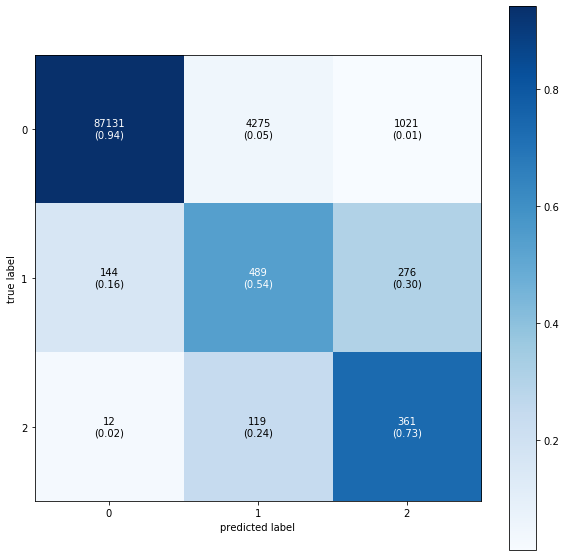

In [37]:
conf=sklearn.metrics.confusion_matrix(labels[880874:],df.iloc[880874:]['final_pred'],labels=[0,1,2])
fig, ax = plot_confusion_matrix(conf_mat=conf,
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True,
                               figsize=(10,10))

In [38]:
from pycm import ConfusionMatrix
cm = ConfusionMatrix(actual_vector=labels[880874:].tolist(), predict_vector=df.iloc[880874:]['final_pred'].tolist())
print (cm.AUC)
print (cm.AUCI)
print (cm.Kappa)

{0: 0.915675844787885, 1: 0.7453326483973746, 2: 0.859921902928209}
{0: 'Excellent', 1: 'Good', 2: 'Very Good'}
0.24926162583685837


In [13]:
df.columns


Index(['tomorrow_net_clicks', 'bot_clicks_feature', 'bcfeature1', 'bcfeature2',
       'bcfeature3', 'bcfeature4', 'cfeature4', 'ifeature4', 'pfeature4',
       'cfeature5', 'cfeature6', 'cfeature7', 'ifeature5', 'ifeature6',
       'ifeature7', 'pfeature5', 'pfeature6', 'pfeature7', 'roll_c_feature2',
       'roll_c_feature3', 'roll_c_feature7', 'roll_c_feature30',
       'roll_i_feature2', 'roll_i_feature3', 'roll_i_feature7',
       'roll_i_feature30', 'roll_p_feature2', 'roll_p_feature3',
       'roll_p_feature7', 'roll_p_feature30', 'bcfeature5', 'bcfeature6',
       'bcfeature7', 'roll_bc_feature2', 'roll_bc_feature3',
       'roll_bc_feature7', 'roll_bc_feature30', 'cfeature4_all',
       'ifeature4_all', 'pfeature4_all', 'cfeature5_all', 'cfeature6_all',
       'cfeature7_all', 'ifeature5_all', 'ifeature6_all', 'ifeature7_all',
       'pfeature5_all', 'pfeature6_all', 'pfeature7_all',
       'roll_c_feature2_all', 'roll_c_feature3_all', 'roll_c_feature7_all',
       'roll_c_fea